# Categorising Buildings in Lausanne Based on Façade Material
This Jupyter Notebook is part of a machine learning project developed in collaboration with the HERUS (Laboratory on Human-Environment Relations in Urban Systems). The objective is to classify Lausanne buildings according to the composition of their facade materials using advanced machine learning techniques.

The following sections will elucidate the technical foundations of our approach...

In [83]:
# For file and directory operations
import os
import shutil

# For manipulating tables and performing mathematical calculations (pip install numpy)
import numpy as np

# For data processing and DataFrame manipulation (pip install pandas)
import pandas as pd

# For HTTP requests (pip install requests)
import requests

# For handling geographic projections (pip install pyproj)
import pyproj
from pyproj import Proj, transform

# For preparing image data (pip install scikit-learn)
from sklearn.model_selection import train_test_split

# For deep learning with PyTorch (pip install torch & pip install torchvision)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.optim.lr_scheduler

# For model evaluation (pip install scikit-learn)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_curve, auc

# For data visualization (pip install matplotlib)
import matplotlib.pyplot as plt

# For image work (pip install pillow)
from PIL import Image

Note that some code cells are not executed in the notebook version shown here. This decision is made for convenience and clarity, as running these cells results in output that generates many extraneous rows. These lines, while relevant when executing the code, could make reading this document more difficult by forcing the reader to scroll through a large volume of non-essential information. Obviously, these code cells were executed during the development and analysis of this project. Their results were used to obtain the visualizations and conclusions presented in this study. So, although not visible directly in the notebook, these steps are crucial for the analysis process and the results obtained.

# 1. Data Collection
In this section, we focus on the initial and essential phase of our project, the collection of data. Data collection refers to the process of gathering a relevant set of image data that is pertinent to our project's objectives.

## Data Sources 
For the collection of our data, we use :

- **Swiss Real Estate Database** : This resource provides detailed information on buildings in Switzerland, extracted from the official building address directory. This register, which includes all official addresses in Switzerland, is established, managed and published by the Federal Office of Topography, swisstopo.

- **Google Street View via the Google Maps API** : We use this API to download images of building facades at specific geographic locations in Lausanne. These images provide an exhaustive visual representation of the facades.

## Data Acquisition
The data acquisition step is crucial because the quality and variety of data collected will have a direct impact on the efficiency and accuracy of our model.

The first step is to load the CSV file which contains detailed information on the buildings from the Swiss Real Estate Database. This file serves as a reference to identify coordinates and other relevant characteristics of buildings.

In [2]:
# Define the file path to the CSV file
file_path = "pure_adr.csv"

# Load the data into a pandas DataFrame
df = pd.read_csv(file_path, sep=';', low_memory=False) # low_memory is set to False to ensure there are no mixed types

In [3]:
# Display the content of the DataFrame
display(df)

,ADR_EGAID,STR_ESID,BDG_EGID,ADR_EDID,STN_LABEL,ADR_NUMBER,BDG_CATEGORY,BDG_NAME,ZIP_LABEL,COM_FOSNR,COM_CANTON,ADR_STATUS,ADR_OFFICIAL,ADR_MODIFIED,ADR_EASTING,ADR_NORTHING
0,101330404,10062448,190052853,0,Schaftenholzweg,24a,non_residential,NaN,2557 Studen BE,749,BE,existing,True,23.10.2023,2589896,1217462
1,102264498,10104686,191591214,0,La Petite Fin,6,non_residential,NaN,2516 Lamboing,726,BE,existing,True,23.10.2023,2577429,1217843
2,102853253,10140788,504022629,0,Itramenstrasse,62a,special,NaN,3818 Grindelwald,576,BE,existing,True,23.10.2023,2642979,1163196
3,100797091,10061808,1336996,0,Winklenstrasse,17,residential,NaN,3714 Frutigen,563,BE,existing,True,23.10.2023,2615998,1160582
4,102199044,10004393,1306005,0,Oberburgstrasse,38d,residential,NaN,3400 Burgdorf,404,BE,existing,True,23.10.2023,2613866,1211081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167660,103505676,10127201,502370199,0,Route de Mangold,46,non_residential,NaN,1958 St-Léonard,6246,VS,existing,False,23.10.2023,2599756,1122549
3167661,103505462,10148057,502369573,0,Impasse du Torrent,6.1,non_residential,NaN,1981 Vex,6089,VS,existing,False,23.10.2023,2596919,1117679
3167662,103505438,10081506,502369717,0,Route d'Hérémence,100.2,non_residential,NaN,1992 Les Mayens-de-Sion,6089,VS,existing,False,23.10.2023,2597009,1116303
3167663,103506184,10105616,502370054,0,Rue des Rocailles,7a,non_residential,NaN,1958 St-Léonard,6246,VS,existing,False,23.10.2023,2599078,1122723


The loaded DataFrame contains important data for our analysis. Here are some key details about this DataFrame :

About the DataFrame structure
- Number of Rows : This DataFrame includes `3,167,665` rows, where each row represents a building in Switzerland.
- Number of columns : This DataFrame includes `16` columns, where each column represents a given attribute.

Here is a brief description of some of the key columns in the DataFrame :

- `ADR_EGAID`: Federal building address identifier
- `STR_ESID`: Federal street identifier
- `BDG_EGID`: Federal building identifier
- `ADR_EDID`: Federal identifier for entries
- `ZIP_LABEL`: Postcode and name of the locality
- `ADR_STATUS`: Status of the address
- `ADR_EASTING`: East coordinate MN95
- `ADR_NORTHING`: North coordinate MN95

The data from this DataFrame will be used to download images of Lausanne buildings.

It is relevant to eliminate unnecessary columns from our DataFrame in order to retain only the essential data for our analysis.

In [4]:
# Create a list of unnecessary columns
useless_columns = ['ADR_EGAID', 'STR_ESID', 'ADR_EDID', 'STN_LABEL', 'ADR_NUMBER', 'BDG_CATEGORY', 'BDG_NAME', 'COM_FOSNR', 'COM_CANTON','ADR_OFFICIAL', 'ADR_MODIFIED']

# Remove these columns from the DataFrame
df = df.drop(columns=useless_columns)

Since our analysis focuses exclusively on buildings in Lausanne, it is necessary to eliminate from our DataFrame all rows that do not correspond to buildings with the `ZIP_LABEL` of 1010 Lausanne.

In [5]:
# Create a new DataFrame containing only the buildings located in Lausanne
df_lausanne = df[df['ZIP_LABEL'] == '1010 Lausanne']

The 'ADR_STATUS' column of our dataset corresponds to the status of the address, and can contain either 'planned', for a building which will be built, or 'existing', for a building already constructed. For our analysis, we are specifically interested in buildings that are marked as 'existing'. This is because we need to work with buildings that currently exist in order to obtain accurate building imagery data. Buildings that do not exist are irrelevant to our analysis, so we will remove them from our dataset.

In [6]:
# Filter the DataFrame to include only buildings that currently exist
df_lausanne = df_lausanne[df_lausanne['ADR_STATUS'] == 'existing']

Here is the DataFrame df lausanne that we obtain on which the rest of our study will be based.

In [7]:
# Display the content of the DataFrame
display(df_lausanne)

,BDG_EGID,ZIP_LABEL,ADR_STATUS,ADR_EASTING,ADR_NORTHING
990592,887076,1010 Lausanne,existing,2539264,1153513
998286,881383,1010 Lausanne,existing,2540321,1154083
999855,881422,1010 Lausanne,existing,2539738,1154001
1000851,280125779,1010 Lausanne,existing,2540104,1154756
1002043,880957,1010 Lausanne,existing,2539869,1154536
...,...,...,...,...,...
3162599,280137156,1010 Lausanne,existing,2540237,1154739
3162600,280137158,1010 Lausanne,existing,2540179,1154726
3162601,280137155,1010 Lausanne,existing,2539240,1154320
3162603,280137156,1010 Lausanne,existing,2540237,1154739


## Coordinate Conversion
In our `df_lausanne` DataFrame, the geographical coordinates of the buildings are stored in the columns `ADR_EASTING` and `ADR_NORTHING`, utilizing the Swiss MN95 (Mittelland-Nord 1995) coordinate system. However, to effectively use the Google Maps API for extracting images of each building, we need to convert these coordinates into the WGS84 format. WGS84 is the standard global geographical coordinate system, ensuring compatibility with worldwide mapping and geospatial data.


Below we define a function that converts geographic coordinates from the Swiss MN95 system to coordinates from the WGS84 system.

In [8]:
# Definition of the function that converts MN95 coordinates to WGS84
def MN95_to_WSG84(coord_EST, coord_NORTH):
    
    # Define the coordinate systems
    proj_swiss = Proj(init='epsg:2056') # MN95 (Swiss coordinate system)
    proj_wgs84 = Proj(init='epsg:4326') # WGS84 (global coordinate system)

    # Input Swiss coordinates (MN95)
    x_mn95, y_mn95 = coord_EST, coord_NORTH

    # Convert to the WGS84 coordinate system
    lon, lat = transform(proj_swiss, proj_wgs84, x_mn95, y_mn95)
    
    # Return the converted coordinates in the format (latitude, longitude)
    return (lat, lon)

All we have to do now is use the `MN95_to_WSG84` function to convert the coordinates of the Swiss coordinate system MN95 into coordinates of the world coordinate system WGS84. The result of this conversion will be stored in two new columns of our `df_lausanne` DataFrame, namely `ADR_LAT` for latitude and `ADR_LON` for longitude.


In [ ]:
# Add a new column 'ADR_LAT' to the 'df_lausanne' DataFrame
# This column will contain the converted latitude values from MN95 to WSG84
df_lausanne['ADR_LAT'] = df_lausanne.apply(lambda row: MN95_to_WSG84(row['ADR_EASTING'], row['ADR_NORTHING'])[0], axis=1)

# Add a new column 'ADR_LON' to the 'df_lausanne' DataFrame
# This column will contain the converted longitude values from MN95 to WSG84
df_lausanne['ADR_LON'] = df_lausanne.apply(lambda row: MN95_to_WSG84(row['ADR_EASTING'], row['ADR_NORTHING'])[1], axis=1)

# Drop the 'ADR_NORTHING' and 'ADR_EASTING' columns, which are no longer needed
df_lausanne.drop(['ADR_NORTHING', 'ADR_EASTING'], axis=1, inplace=True)

After performing all these DataFrame manipulations, we have arrived at `df_lausanne`, the DataFrame that will enable us to obtain photos of buildings in Lausanne using the Google Image API.


In [10]:
# Display the content of the DataFrame
display(df_lausanne)

,BDG_EGID,ZIP_LABEL,ADR_STATUS,ADR_EASTING,ADR_NORTHING
990592,887076,1010 Lausanne,existing,2539264,1153513
998286,881383,1010 Lausanne,existing,2540321,1154083
999855,881422,1010 Lausanne,existing,2539738,1154001
1000851,280125779,1010 Lausanne,existing,2540104,1154756
1002043,880957,1010 Lausanne,existing,2539869,1154536
...,...,...,...,...,...
3162599,280137156,1010 Lausanne,existing,2540237,1154739
3162600,280137158,1010 Lausanne,existing,2540179,1154726
3162601,280137155,1010 Lausanne,existing,2539240,1154320
3162603,280137156,1010 Lausanne,existing,2540237,1154739


## Street View Image Retrieval
In this section, we'll explore how to retrieve Street View images of the buildings contained in the `df_lausanne` DataFrame using the Google Street View API. These images provide a visual representation of the facades which interests us in the context of our study.

We need to define a function that allows us to send a request to the Google Street View API to obtain a Street View image based on the provided latitude and longitude coordinates. The function will then save this image to a file with the specified name.

In [11]:
# Create the 'images_bat' directory if it doesn't exist
output_dir = 'images_bat'
os.makedirs(output_dir, exist_ok=True)

# Definition of the function that retrieves Street View images based on building coordinates and API key
def get_street_view_image(lat, lon, api_key, file_name):
    
    # Construct the URL for the API request
    base_url = "https://maps.googleapis.com/maps/api/streetview"
    params = {
        "size": "610x610",  # Image size
        "location": f"{lat},{lon}",  # Latitude and Longitude
        "key": api_key,  # API key
    }

    # Send the request to the Google Street View API
    response = requests.get(base_url, params=params)

    # Check if the response status code is 200 (OK)
    if response.status_code == 200:
        # Write the image content to a file in the 'images_bat_2' directory
        with open(os.path.join(output_dir, file_name), "wb") as file:
            file.write(response.content)
    else:
        print("Error downloading the image !")  # Print an error message if the request fails.

So, now, we have to retrieve and download the Street View image of the facade of each of the Lausanne buildings using the Google Street View API. The image is saved and named by including its corresponding index in the DataFrame. This makes it easy to identify which row of the DataFrame each image is associated with, if necessary.

*-> DO NOT LAUNCH THIS CELL, the API key is hidden and the image_bat file obtained thanks to this cell is already provided !*

In [ ]:
# Define the API key for Google Street View
api_key = "personal_api_key_hidden" # api_key = "AIzaSyDdy..."

# Loop through each row (each building located in Lausanne) in the DataFrame 'df_lausanne_head'
for index, row in df_lausanne.iterrows():
    # Retrieve a Street View image of the building and save it as 'image_bat_<index>.jpg'
    get_street_view_image(row['ADR_LAT'], row['ADR_LON'], api_key, "image_bat_{}.jpg".format(index))

## First Analysis of Street View Images
Now that we have gathered our images, the next step involves conducting a brief analysis to understand the nature and characteristics of the 1437 images that we have collected. This analysis will provide us with valuable insights into the dataset, including the diversity of the images, their quality, and how well they represent the scope of our project. Understanding our data at this early stage is crucial for guiding subsequent phases of the project, particularly in terms of preprocessing and model training.

One of the first things we notice when opening the file containing the downloaded images is the presence of blank images with the text "sorry, we have no imagery here.". These images appear blank because Google Street View did not capture any imagery for the corresponding building. These blank images are unusable for our model, so we delete them from our image folder. As a result, we have decided to not include these blank images in our analysis. Therefore, we will remove them from our DataFrame to ensure that only relevant and usable images are considered in our study.

Here is an example of a blank image downloaded from a Google Street View for a building in Lausanne :
<img src="/illustrations/blank.jpg" width="200">

In [12]:
# List of indexes to delete corresponding to buildings with blank image
indexes_to_drop = [990592, 998286, 1008884, 1012599, 1012821, 1013864, 1014357, 1015711, 1017292, 1017750, 1018451, 1019010, 1019392, 1020139, 1021973, 1026087, 1027289, 1030008, 1030009, 1032820, 1036061, 1040273, 1042050, 1042248, 1045218, 1045793, 1046954, 1048312, 1048796, 1050298, 1050446, 1051022, 1053290, 1054324, 1054549, 1056123, 1056590, 1056855, 1058516, 1058970, 1061407, 1061831, 1062929, 1064060, 1064752, 1064953, 1064974, 1067302, 1073106, 1074228, 1075742, 1076664, 1076687, 1077030, 1077458, 1077663, 1077708, 1079995, 1081835, 1082758, 1082878, 1082944, 1086554, 1086710, 1087925, 1088303, 1089792, 1092510, 1093783, 1095119, 1095508, 1095826, 1095851, 1095993, 1097091, 1098035, 1103506, 1104059, 1104074, 1106507, 1106991, 1107056, 1109204, 1111446, 1117669, 1120020, 1120329, 1120588, 1120929, 1123494, 1124496, 1125672, 1126274, 1126625, 1127836, 1129136, 1129737, 1130062, 1130395, 1130889, 1130897, 1131429, 1131544, 1134089, 1134231, 1134522, 1134988, 1135085, 1135502, 1135886, 1136162, 1136241, 1137108, 1137576, 1137585, 1138064, 1138956, 1139179, 1140374, 1140397, 1141123, 1141923, 1142432, 1143798, 1149873, 1151140, 1152976, 1153156, 1153757, 1154356, 1154509, 1155984, 1156901, 1158201, 1159272, 1159291, 1159842, 1159915, 1161327, 1161696, 1161765, 1161830, 1162545, 1163364, 1163384, 1164265, 1164851, 1165088, 1165523, 1168723, 1168917, 1169883, 1171460, 1173292, 1173925, 1175095, 1181655, 1181914, 1182075, 1182597, 1184438, 1185089, 1185998, 1186182, 1186761, 1186769, 1186774, 1187103, 1187621, 1188134, 1188790, 1189284, 1190423, 1191056, 1192919, 1193510, 1194000, 1194216, 1194554, 1196002, 1196196, 1196945, 1199989, 1200168, 1200695, 1202939, 1203376, 1203429, 1206706, 1207423, 1207852, 1208100, 1208383, 1209297, 1212801, 1213615, 1213702, 1215047, 1215223, 1217205, 1217271, 1217633, 1217670, 1218098, 1222051, 1222431, 1222952, 1223088, 1223090, 1223581, 1225393, 1225884, 1227265, 1227350, 1227956, 1227998, 1228739, 1228978, 1229696, 1229819, 1230435, 1230524, 1231645, 1232189, 1232661, 1233238, 1233290, 1233541, 1233812, 1234531, 1235086, 1235572, 1235802, 1236158, 1236261, 1240059, 1240216, 1240385, 1240608, 1240882, 1241104, 1241141, 1241967, 1244186, 1244223, 1244807, 1245366, 1245996, 1246524, 1246760, 1246910, 1249104, 1249398, 1249674, 1250710, 1251366, 1255299, 1255690, 1257590, 1258026, 1258207, 1259664, 1259881, 1260233, 1260294, 1260532, 1260552, 1262726, 1264009, 1265044, 1265359, 1269822, 1270318, 1270516, 1271323, 1271408, 1271859, 1272750, 1272810, 1274141, 1274718, 1276731, 1278391, 1278929, 1280714, 1280898, 1281871, 1282105, 1284489, 1284597, 1285632, 1290948, 1291896, 1295601, 1296645, 1297708, 1299265, 1302435, 1302691, 1302957, 1303359, 1304302, 1305815, 1306425, 1306575, 1306613, 1306679, 1306748, 1307927, 1308545, 1309270, 1311285, 1312473, 1313238, 1313282, 1314392, 1316466, 1318540, 1320099, 1321049, 1321660, 1321698, 1322014, 1322232, 1322306, 1323437, 1323456, 1324010, 1329183, 1329277, 1329924, 1330423, 1332886, 1335736, 1335739, 1337565, 1338290, 1339106, 1340359, 1342251, 1343824, 1344640, 1344682, 1345096, 1345122, 1345911, 1345968, 1346822, 1349536, 1349759, 1350377, 1350740, 1350771, 1351321, 1354095, 1357274, 1357341, 1357605, 1357673, 1358219, 1359386, 1360285, 1360331, 1362466, 1363528, 1364140, 1364622, 1367586, 1367630, 1367745, 1368328, 1369315, 1369827, 1372142, 1373739, 1373806, 1375482, 1376769, 1378333, 1378343, 1380322, 1382546, 1384429, 1384626, 1385142, 1385166, 1385554, 1388695, 1393425, 1395072, 1395110, 1395209, 1396739, 1399065, 1399107, 1399342, 1400094, 1401815, 1402817, 1405068, 1408910, 1418729, 1418987, 1420397, 1420832, 1422062, 1422428, 1422694, 1423805, 1424307, 1424900, 1425355, 1427013, 1427101, 1427258, 1428395, 1429423, 1430025, 1432131, 1434545, 1437061, 1437901, 1437951, 1438450, 1439022, 1440803, 1442435, 1443058, 1446279, 1446379, 1447000, 1447117, 1447801, 1453512, 1457976, 1458417, 1459493, 1461194, 1462389, 1468478, 1468834, 1469847, 1471537, 1472815, 1473486, 1474878, 1477438, 1478473, 1478829, 1478959, 1479008, 1481368, 1481381, 1482130, 1484268, 1485104, 1485281, 1485548, 1486333, 1487926, 1488290, 1488384, 1489156, 1489353, 1490412, 1491329, 1491534, 1491645, 1492068, 1493848, 1493998, 1494402, 1495958, 1500693, 1501257, 1504312, 1512099, 1513408, 1513808, 1516366, 1518785, 1543024, 1546838, 1546882, 1547907, 1548881, 1551177, 1552348, 1553320, 1573970, 1575045, 1583598, 2432588, 2442386, 2602498, 2612837, 2620270, 2763268, 2777510, 2777521, 2778037, 2778039, 2889963, 2892955, 2894673, 2894702, 2895211, 2895213, 2895505, 2903383, 2903924, 2904495, 2910781, 3082742, 3082758, 3084353, 3087087, 3162599, 3162603]

# Delete the rows in question from our DataFrame
df_lausanne = df_lausanne.drop(indexes_to_drop)

# Display the content of the DataFrame
display(df_lausanne)

,BDG_EGID,ZIP_LABEL,ADR_STATUS,ADR_EASTING,ADR_NORTHING
999855,881422,1010 Lausanne,existing,2539738,1154001
1000851,280125779,1010 Lausanne,existing,2540104,1154756
1002043,880957,1010 Lausanne,existing,2539869,1154536
1002197,880856,1010 Lausanne,existing,2539448,1154327
1002512,881044,1010 Lausanne,existing,2539211,1153717
...,...,...,...,...,...
3162597,280137157,1010 Lausanne,existing,2540210,1154754
3162598,280137158,1010 Lausanne,existing,2540179,1154726
3162600,280137158,1010 Lausanne,existing,2540179,1154726
3162601,280137155,1010 Lausanne,existing,2539240,1154320


Thus, we discover that there are 519 buildings in Lausanne for which Google Street View did not provide any images. Consequently, we are left with 918 images of Lausanne buildings that could potentially be usable for our analysis.

Looking at the images we collected after removing blank images, we realize that the quality and clarity of the images vary considerably. Several factors contribute to this variability. This is because some images are blurry, which may be due to Google Street View camera movement or focus issues when capturing the image. Many other shots are partially or completely obstructed by elements such as trees, vehicles or passers-by, thus hiding part or all of the facade of the buildings. In some cases, coordinates purporting to represent a building result in images where the building in question is not visible, or is poorly positioned within the photo frame. Also, sometimes images show two neighboring buildings in a single view, which can be confusing during analysis and classification. Additionally, features like fencing can prevent the full facade of a building from being seen, limiting the information available for analysis. Finally, some images are taken from too far away, or from angles that do not allow a clear and complete view of the facades. These imperfections are likely to significantly impact the performance of our model and underline the importance of careful data preprocessing to improve the quality of the dataset before training the model.

In addition to the aforementioned issues with our images, we are also facing a significant challenge with data imbalance in our dataset. Of the 918 usable images, less than 10 fall into the stone class, similarly for the brick and mix classes. The majority are split between concrete facades and those classified as other. This imbalance can harm the performance and generalization ability of our model, as it can become biased towards the most represented classes and thus lead to potential overfitting or underfitting problems.

To resolve these issues and create a more complete and balanced `dataset`, we decided to undertake the creation of a new dataset. This new dataset will be curated by selecting the best images from our original collection obtained via the Google Street View API and supplementing them with additional images. We'll manually capture screenshots of Google Street View, which will help us limit the obstruction and perspective issues we've had with the API. In addition, we will add images of building facades taken from datasets available on the Internet to further enrich our dataset. Finally, we also ensure that the number of classes is fairly balanced.

The new, enhanced dataset will be organized into a file named dataset, consisting of subfolders named according to the classes (stone, brick, mix, concrete, and other). This structured approach not only promises a more balanced representation of each category but also ensures better quality control of the images, thus laying a stronger foundation for the training of our CNN model. By diversifying our image sources and carefully selecting our data, we aim to mitigate the limitations of our initial dataset and improve the potential outcomes of our project.

## Labeling Images
Finally, the last step is labeling our uploaded images. Manually, for each building facade image in Lausanne, we need to move them to a subfolder named by the class they should be assigned to, based on the construction material of the building facade.

We decided to classify the images according to 5 classes :
- **brick** : for buildings with brick facade, distinguishable by the texture and color of the surface of the facade, the bricks generally have a grainy appearance and a natural shade which can vary from red to brown, but can be painted, with gray for example.
- **stone** : for buildings with stone facades, these facades generally have a smoother texture than those made of brick and feature details such as veins, patterns or color variations typical of different types of stone.
- **concrete** : for buildings with concrete facades, generally, they present a smooth and solid surface with a uniform appearance, without grain pattern or color variation and cleaner finishes than the two previous facades.
- **mix** : for buildings with mixed material facades. We have decided to include in this category facades presenting a combination of at least two distinct types of materials. Carefully observing the facade surface to spot sharp transitions between materials can help distinguish these facades.
- **other** : for building with facades that cannot be identified from the image, as, for example, in the case where the building is obscured by trees, passing vehicles or scaffolding. This category will also contain buildings with a facade different from the four categories above, such as wood, glass, etc.

Here is an example of a facade taken from the buildings of Lausanne for each of the five classes : 
<img src="/illustrations/classes.jpg" width="800">

Now, we can move on to the next step...

# 2. Data Preprocessing

In this section, we focus on the preprocessing of the images that constitute the dataset that we built, as explained previously. Data preprocessing refers to the manipulation of data before it is used in order to ensure or improve performance, and is an important step in the data mining process.

## Prepare Directory Structure
Initially, the setup of directory organization is required to accommodate both training and testing data designated for machine learning purposes.

In [13]:
# Path to the main directory where the data is located
data_dir = 'dataset'

# List of classes in the dataset
classes = ['brick', 'concrete', 'mix', 'other', 'stone']

# Base paths for training and testing directories
base_train_dir = "train" # Base path for training directory
base_test_dir = "test" # Base path for testing directory

# Creation of directories for each class in the training and test directories
for cls in classes:
    # Creation of directories for each class in the training directory
    os.makedirs(os.path.join(base_train_dir, cls), exist_ok=True)
    # Creation of directories for each class in the testing directory
    os.makedirs(os.path.join(base_test_dir, cls), exist_ok=True)

## Data Division
The next step consists of distributing the images of each class of the dataset into the training and test folders according to certain proportions. We will allocate 70% of the dataset for training and 30% for testing. This balanced distribution aims to provide the model with 70% of the data for training, thus allowing good acquisition of the characteristics of the different classes. Then, the remaining 30% is used to evaluate the performance of the model on data not seen during training. This helps estimate the model's ability to generalize to new observations, while limiting the risk of overfitting the model to specific training data.

In [14]:
# Iteration over all classes of the dataset
for cls in classes:
    # List of files in the source directory
    files = os.listdir(os.path.join(data_dir, cls))
    
    # Separation of files into training (70%) and testing (30%) sets
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)

    # Copy files to corresponding destination directories (training directory)
    for file in train_files:
        src_path = os.path.join(data_dir, cls, file)
        dest_path = os.path.join(base_train_dir, cls, file)
        shutil.copy(src_path, dest_path)

    # Copy files to corresponding destination directories (testing directory)
    for file in test_files:
        src_path = os.path.join(data_dir, cls, file)
        dest_path = os.path.join(base_test_dir, cls, file)
        shutil.copy(src_path, dest_path)

## Data Transformation

Now, we define the data transformations to apply to images before using them for training and testing machine learning models. These transformations are used to prepare images to improve the model's ability to learn relevant patterns and generalize to new data.

But before moving on to data transformation, we need to find the mean and standard deviation values, from the training and testing data, which will be used for normalization (or standardization) of the data in order to obtain data centered on the mean and with unit variance (standard deviation). Data normalization is the process of transforming raw data into a standardized format, often by adjusting the values so that they fall within a specific range.

In [15]:
# Define a dataset without normalization for calculating mean and std for training set
train_unnormalized_dataset = datasets.ImageFolder(base_train_dir, transform=transforms.ToTensor())
test_unnormalized_dataset = datasets.ImageFolder(base_test_dir, transform=transforms.ToTensor())

# Calculate mean and standard deviation across the entire dataset for testing set
data_loader_train = torch.utils.data.DataLoader(train_unnormalized_dataset, batch_size=1, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(test_unnormalized_dataset, batch_size=1, shuffle=False)

train_mean = torch.zeros(3)
train_std = torch.zeros(3)
total_samples_train = len(train_unnormalized_dataset)

test_mean = torch.zeros(3)
test_std = torch.zeros(3)
total_samples_test = len(test_unnormalized_dataset)

# Iterate through the dataset to compute the mean and standard deviation for training set
for inputs, _ in data_loader_train:
    train_mean += torch.mean(inputs, dim=(0, 2, 3)) # Calculate mean along channels (RGB)
    train_std += torch.std(inputs, dim=(0, 2, 3)) # Calculate std along channels (RGB)

# Iterate through the dataset to compute the mean and standard deviation for testing set
for inputs, _ in data_loader_test:
    test_mean += torch.mean(inputs, dim=(0, 2, 3)) # Calculate mean along channels (RGB)
    test_std += torch.std(inputs, dim=(0, 2, 3)) # Calculate std along channels (RGB)

train_mean /= total_samples_train
train_std /= total_samples_train

test_mean /= total_samples_test
test_std /= total_samples_test

# Print the calculated mean and std for training set
print(f"Calculated train mean : {train_mean}")
print(f"Calculated train std : {train_std}")

print()

# Print the calculated mean and std for testing set
print(f"Calculated test mean : {test_mean}")
print(f"Calculated test std : {test_std}")

Calculated train mean : tensor([0.4549, 0.4410, 0.4144])
Calculated train std : tensor([0.2017, 0.1996, 0.2104])

Calculated test mean : tensor([0.4576, 0.4307, 0.3988])
Calculated test std : tensor([0.2064, 0.2021, 0.2115])


The main objective of data transformations is to perform several modifications on images, including increasing the diversity of training data by applying random transformations to images, this is called data augmentation. This helps improve the robustness of the model and its ability to generalize.

Here is an overview of the transformations applied to the data used for training:

- **Resize() :** Resizing all images to ensure a uniform size since our images come from several sources and, therefore, do not have the same dimensions.

- **RandomHorizontalFlip() :** Performs random horizontal inversion of images, allowing variations in position or orientation to be captured.

- **RandomVerticalFlip() :** Performs random vertical inversion of images, allowing variations in position or orientation to be captured.

- **RandomCrop() :** Performs random cropping of images to obtain smaller subimages, this helps focus the model on specific parts of the images.

- **RandomGrayscale() :** Performs a random conversion of the image to different gray levels to improve the generalization ability of the model.

- **RandomAffine() :** Performs random transformations of images on the x and y axis to introduce position variability. Can also randomly zoom images or introduce random shearing to change the shape of the image.

- **GaussianBlur() :** Applies a Gaussian blur to smooth out noise and irrelevant details.

- **ColorJitter() :** Adjusts randomly the brightness of images to introduce lighting variations.

- **ToTensor() :** Converts images to tensors to be processed by the model.

- **Normalize() :** Normalizes the pixel values of images, which helps improve training stability and reduces bias introduced by differences in the scale of pixel values.

In [134]:
# Define data transforms including normalization and data augmentation
data_transforms = {
    # Transformations to be carried out on the training set
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # Resizes all images to 224x224 pixels
        transforms.RandomHorizontalFlip(), # Random horizontal flip
        transforms.RandomVerticalFlip(), # Random vertical flip
        transforms.GaussianBlur(kernel_size=3), # Gaussian blur with kernel size 3
        transforms.RandomCrop(size=100), # Random crop to a size of 100x100 pixels
        transforms.RandomGrayscale(), # Random grayscale conversion
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), # Random translation of 20% maximum
        transforms.RandomAffine(degrees=0, scale=(1.1, 1.5)), # Random zoom between 1.1 and 1.5 times the size
        transforms.RandomAffine(degrees=0, shear=10), # Random shear of up to 10 degrees
        transforms.ColorJitter(brightness=0.5), # Random variation of brightness
        transforms.ToTensor(), # Convert images to tensors
        transforms.Normalize(mean=train_mean, std=train_std) # Normalization of pixel values
    ]),
    # Transformations to be carried out on the testing set
    'test': transforms.Compose([
        transforms.Resize((224, 224)), # Resizes all images to 224x224 pixels
        transforms.ToTensor(), # Convert images to tensors
        transforms.Normalize(mean=test_mean, std=test_std) # Normalization of pixel values
    ])
}

Thus, we perform data augmentation on the training set in order to introduce variations in the data, such as rotations, flips, cropping and color alterations, etc. We thus simulate different scenarios and enrich the diversity of images provided to the model. However, these augmentations are not applied to the test set, as this is intended to evaluate the real performance of the model on unaltered data, representative of what it will encounter in a real-world context. Thus, the images in the test set are only subjected to essential transformations such as resizing to have a uniform size, normalization to stabilize pixel values, and conversion to tensors (ToTensor) to make them compatible with the model, without altering their visual characteristics.

## Loading and Preparing Data

Finally, all we have to do is load the images from the training and test directories and preprocess this data by applying the transformations specified above for both sets

In [127]:
# Load training and testing data
train_data = datasets.ImageFolder(base_train_dir, transform=data_transforms['train'])
test_data = datasets.ImageFolder(base_test_dir, transform=data_transforms['test'])

# Create data loaders for training and testing data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Now, we can move on to the next step...

# 3. Building the Model
In this section, we focus on the construction of the building image classification model according to the facade construction material. Building the model consists of defining the architecture, structure and parameters of the model that will be used to solve the classification. This is a crucial step because the performance of the model depends largely on its design. But before moving on to the models, let's implement two useful functions for our analysis.

First, the training function, named `train_model`, essential to allow the model to learn from the data and adjust its internal parameters in order to perform the classification task optimally. The training consists of a loop that iterates over epochs (training cycles) to adjust the model weights, necessary to make predictions from the input data. It is an iterative process that requires the repeated presentation of training data to the model, with incremental adjustments to improve its performance.

In [18]:
def train_model(model, train_loader, device, optimizer, criterion, epoch, num_epochs) :
    # Put the model in training mode
    model.train() 
    # Loss initialization in progress
    running_train_loss = 0.0 

    # Iteration over batches (mini-batches) of training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images) # Passing images into the model to obtain predictions
        train_loss = criterion(outputs, labels) # Calculation of loss (error)
        train_loss.backward() # Backpropagation : calculation of gradients for each parameter of the model
        optimizer.step() # Update model parameters based on calculated gradients
        running_train_loss += train_loss.item() # Addition of the current loss to the accumulation of current losses

    # Displaying the average loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss : {running_train_loss / len(train_loader)}")
    
    return running_train_loss

Next, the evaluation function, named `eval_model`, which consists of measuring the performance and prediction quality of the model on an independent test dataset. So, the main goal of the evaluation is to understand how well the model is able to generalize to new data that was not used during training. To evaluate our model, we will use reputable evaluation metrics to measure the performance obtained.

In [19]:
def eval_model(model, test_loader, device, criterion):
    # Put the model to evaluation mode
    model.eval()
    # Loss initialization in progress
    running_test_loss = 0.0 
    # Initialize empty lists to store labels, predictions, and probabilities
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        # Iteration over testing data
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Perform forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability as the prediction
            probabilities = torch.nn.functional.softmax(outputs, dim=1) # Calculate class probabilities using softmax
            test_loss = criterion(outputs, labels) # Calculation of loss (error)
            running_test_loss += test_loss.item() # Addition of the current loss to the accumulation of current losses

            # Extend the lists with the actual labels, predicted labels, and probabilities
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())

    # Convert the list of probability arrays into a single NumPy array
    all_probabilities_np = np.vstack(all_probabilities)
    
    return all_labels, all_predictions, all_probabilities_np, running_test_loss

Now we can move on to building the models...

## A. Pre-trained VGG-16

VGG-16 is a variant of VGG model which has 13 convolutional layers and 3 fully connected layers, totaling 16 trainable layers. VGG-16 is characterized by its simplicity and depth, following a very linear and sequential architecture. Therefore, VGG-16 is a good initial model to attempt to understand the first results that can be obtained when classifying our building images based on the construction material of their facades.

### Model Preparation
First of all, we have to prepare the model in order to be able to move on to the training and testing phases. This involves retrieving the VGG-16 model pre-trained on the ImageNet dataset, this means that the model has already been trained to extract features from images, but it will need to be adapted to our specific classification task, including replacing the last layer (classify) with a new linear layer (nn. Linear) with a number of output neurons equal to the number of classes in our dataset, i.e. 5 neurons. Preparing the model pass also requires defining the loss function to be used to measure the difference between the model predictions and the actual labels. Here we will use `nn.CrossEntropyLoss()`, commonly used for multiclass classification. Finally, the optimizer must also be configured to adjust the model weights during training. In our case, we will use the Adam optimizer with a learning rate of 0.001, known for its speed of convergence.

In [21]:
def prep_vgg(num_classes, learning_rate):
    # Load pre-trained VGG-16 model
    model = models.vgg16(pretrained=True)
    num_features = model.classifier[6].in_features

    # Customize the fully connected layer (classifier) for classification task
    model.classifier[6] = nn.Linear(num_features, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer

# Prepare the model :
model_VGG, criterion_VGG, optimizer_VGG = prep_vgg(len(train_data.classes), learning_rate=0.001)

### Model Training
We can now move on to the training phase. Before iterating over training data batches loaded from `train_loader`, the number of training epochs must be defined. An epoch corresponds to a complete pass through the training dataset, in our case we decided to choose a reasonable number.

In [22]:
# Train the model :

# Number of training epochs chosen
num_epochs_VGG = 10  

# Use of GPU if available, otherwise of CPU
device_VGG = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_VGG.to(device_VGG)

# Training loop over multiple epochs (10 epochs)
for epoch in range(num_epochs_VGG):
    _ = train_model(model_VGG, train_loader, device_VGG, optimizer_VGG, criterion_VGG, epoch, num_epochs_VGG)

Epoch [1/10] - Loss : 1.790871113538742
Epoch [2/10] - Loss : 1.6457682847976685
Epoch [3/10] - Loss : 1.842295616865158
Epoch [4/10] - Loss : 1.6070037186145782
Epoch [5/10] - Loss : 1.5784419775009155
Epoch [6/10] - Loss : 1.6268291473388672
Epoch [7/10] - Loss : 1.6046547293663025
Epoch [8/10] - Loss : 1.5648343563079834
Epoch [9/10] - Loss : 1.5830583274364471
Epoch [10/10] - Loss : 1.5732731521129608


### Model Evaluation
The training of the model carried out, we can now focus on evaluating the model. Then, to assess the model's performance, we will utilize well-established evaluation metrics to gauge the results achieved.

In [23]:
# Evaluate the model :
all_labels_VGG, all_predictions_VGG, _, _ = eval_model(model_VGG, test_loader, device_VGG, criterion_VGG)

Calculating accuracy is a common practice when assessing the effectiveness of a classification model, such as in the case of classifying building images based on their facade construction materials. Accuracy quantifies the percentage of accurate predictions made by the model among all the data samples. This calculation is valuable because it provides insights into how well the model performs in correctly categorizing the images, helping us gauge its overall classification capabilities.

In [24]:
# Calculate accuracy by comparing actual labels with predicted labels
accuracy_VGG = np.mean(np.array(all_labels_VGG) == np.array(all_predictions_VGG))

# Print the accuracy as a percentage
print(f"Accuracy (VGG-16) : {accuracy_VGG * 100:.2f}%")

Accuracy (VGG-16) : 23.64%


We obtain an accuracy of approximately 20%, which means that, on the test dataset, the model correctly classified almost 20% of the samples into the correct categories. This indicates that the model has very poor performance, because it misclassifies the vast majority of samples, it is almost equivalent to the random classifier (probability of 1 in 5, that is to say 20%, that it correctly assigns the class to each sample).

The F1 score is an alternative evaluation measure that combines precision and recall, assessing the predictive capability of a model by examining its performance per class rather than a global performance, as precision does. Calculating the F1 score in multi-class classification is relevant because it provides a more comprehensive assessment of the model's performance compared to accuracy alone.

In [25]:
# Define class names
class_names_VGG = ["brick", "concrete", "mix", "other", "stone"]

# Calculate F1 score for each class and store them in a list
f1_scores_VGG = f1_score(all_labels_VGG, all_predictions_VGG, average=None)

# Print F1 score for each class
for i, score in enumerate(f1_scores_VGG):
    print(f"F1 score for {class_names_VGG[i]} : {score:.2f}")

# Calculate the average F1 score across all classes
average_f1_score_VGG = f1_score(all_labels_VGG, all_predictions_VGG, average='weighted')

# Print the average F1 score
print()
print(f"Average F1 score (VGG-16) : {average_f1_score_VGG:.2f}")

F1 score for brick : 0.38
F1 score for concrete : 0.00
F1 score for mix : 0.00
F1 score for other : 0.00
F1 score for stone : 0.00

Average F1 score (VGG-16) : 0.09


The F1 score is usually between 0 and 1, where 1 means perfect performance and 0 means very poor performance. Like accuracy, the average F1 score (≈ 0.10) we obtain suggests very poor performance, indicating that the model struggles to make accurate predictions and correctly capture positive examples in the data. The F1 score of around 0.00 for classes other than “brick” indicates that the model encounters significant difficulties in classifying images of buildings whose facades are made of materials other than this one. However, its results are slightly better when categorizing buildings with brick, but the result is still very low. So, in general, the model does not balance precision and recall. These results indicate that there is room for improvement and that it may be useful to explore alternative models to improve performance.

## B. Pre-trained ResNet-50

ResNet-50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. ResNet-50 is newer and less simple than the VGG-16 model previously used. ResNet is known for its ability to train deep networks without encountering gradient backpropagation issues, it can be an excellent choice for precise classification.

### First Results

In the same way that we prepared the VGG-16 model for our specific classification task, trained it and then tested it on the test set, we will replicate this procedure for the ResNet-50 model in the hope of get better performance. Our main goal is to compare these two neural network architectures using a range of diverse evaluation metrics.

In [26]:
def prep_resnet(num_classes, learning_rate, weight_decay_value=0) :
    # Load pre-trained ResNet model
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features

    # Customize the fully connected layer (classifier) for classification task
    model.fc = nn.Linear(num_features, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
    
    return model, criterion, optimizer

In [28]:
# Prepare the model :
model_ResNet, criterion_ResNet, optimizer_ResNet = prep_resnet(len(train_data.classes), learning_rate=0.001)

# Initialize lists to store metrics
epoch_train_losses_ResNet = []
epoch_test_losses_ResNet = []

# Train the model :

# Number of training epochs chosen
num_epochs_ResNet = 10  

# Use of GPU if available, otherwise of CPU
device_ResNet = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_ResNet.to(device_ResNet)

# Training loop over multiple epochs (10 epochs)
for epoch in range(num_epochs_ResNet):
    running_train_loss_ResNet = train_model(model_ResNet, train_loader, device_ResNet, optimizer_ResNet, criterion_ResNet, epoch, num_epochs_ResNet)
    
    # Follow the evolution of losses over time   
    average_train_loss_ResNet = running_train_loss_ResNet / len(train_loader)
    epoch_train_losses_ResNet.append(average_train_loss_ResNet)

    # Evaluate the model :
    all_labels_ResNet, all_predictions_ResNet, all_probabilities_np_ResNet, running_test_loss_ResNet = eval_model(model_ResNet, test_loader, device_ResNet, criterion_ResNet)
    
    # Follow the evolution of losses over time 
    average_test_loss_ResNet = running_test_loss_ResNet / len(test_loader)
    epoch_test_losses_ResNet.append(average_test_loss_ResNet)

Epoch [1/10] - Loss : 1.7275618612766266
Epoch [2/10] - Loss : 1.7949755191802979
Epoch [3/10] - Loss : 1.622752457857132
Epoch [4/10] - Loss : 1.4044963717460632
Epoch [5/10] - Loss : 1.239497572183609
Epoch [6/10] - Loss : 1.3255824148654938
Epoch [7/10] - Loss : 1.3076674938201904
Epoch [8/10] - Loss : 1.1131810247898102
Epoch [9/10] - Loss : 1.1023043245077133
Epoch [10/10] - Loss : 1.3202925622463226


Let's start by calculating accuracy to quantify the percentage of successful predictions made by the model.

In [29]:
# Calculate accuracy by comparing actual labels with predicted labels
accuracy_ResNet = np.mean(np.array(all_labels_ResNet) == np.array(all_predictions_ResNet))

# Print the accuracy as a percentage
print(f"Accuracy (ResNet-50) : {accuracy_ResNet * 100:.2f}%")

Accuracy (ResNet-50) : 41.82%


We obtain an accuracy of a little more than of 40%, which means that, on the test dataset, the model correctly classified more than 2/5 of the samples into the correct categories. This indicates that the model has acceptable performance, much higher than that of the VGG-16 model previously tested, but can still be improved.

To compare the success of ResNet-50 with VGG-16, we can calculate the F1-score of each class, it's a comprehensive evaluation for the performance.

In [30]:
# Define class names
class_names_ResNet = ["brick", "concrete", "mix", "other", "stone"]

# Calculate F1 score for each class and store them in a list
f1_scores_ResNet = f1_score(all_labels_ResNet, all_predictions_ResNet, average=None)

# Print F1 score for each class
for i, score in enumerate(f1_scores_ResNet):
    print(f"F1 score for {class_names_ResNet[i]} : {score:.2f}")

# Calculate the average F1 score across all classes
average_f1_score_ResNet = f1_score(all_labels_ResNet, all_predictions_ResNet, average='weighted')

# Print the average F1 score
print()
print(f"Average F1 score (ResNet-50) : {average_f1_score_ResNet:.2f}")

F1 score for brick : 0.50
F1 score for concrete : 0.50
F1 score for mix : 0.17
F1 score for other : 0.52
F1 score for stone : 0.00

Average F1 score (ResNet-50) : 0.38


The F1 score typically ranges between 0 and 1, where 1 signifies perfect performance and 0 indicates very poor performance. Similar to accuracy, the average F1 score (0.35) suggests moderate performance, indicating room for improvement. The F1 score of 0.00 for the stone class indicates that the model struggles to classify images of buildings with stone facades. This may be due to the wide variety of colors and texture that stones can have. However, the model demonstrates relatively strong performance for three of the classes : brick, concrete and othe, as the F1 score is around 0.50. So, the model effectively balances precision and recall for theses three classes. Thus, the same conclusions made after calculating the accuracy can be made by analyzing the F1 score, the ResNet-50 model is more efficient than the VGG-16 model.

Plotting Receiver Operating Characteristic (ROC) curves for each class in the context of multi-class classification is a valuable practice for a more detailed model evaluation, providing insights into its performance for individual classes. Therefore, class-specific ROC curves offer a finer-grained assessment by showcasing the model's performance for each class separately. Each ROC curve illustrates how the sensitivity (true positive rate) of a class varies with specificity (true negative rate) at different classification thresholds. This enables an analysis of how the model makes decisions for each class at different confidence levels. Consequently, by comparing ROC curves across different classes, you can identify classes where the model excels (high area under the curve) and those where it performs less effectively, thus revealing which classes pose greater classification challenges.

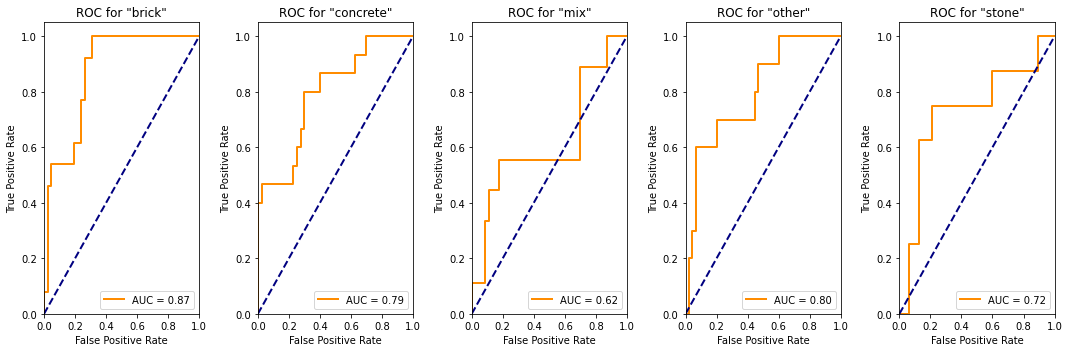

In [31]:
# Adjust the figure size to accommodate 5 subplots
plt.figure(figsize=(15, 5))  

for i, class_name in enumerate(class_names_ResNet):
    # Calculate the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(all_labels_ResNet, all_probabilities_np_ResNet[:, i], pos_label=i) # Calculate the FP dnd TP rates
    roc_auc = auc(fpr, tpr) # Calculate the area under the ROC curve (AUC)
    plt.subplot(1, 5, i + 1) # Create a subplot for each class
    
    # Plot the ROC curve for each class
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for "{class_name}"')
    plt.legend(loc="lower right")

# Adjust the spacing between subplots and display plots
plt.tight_layout()
plt.show()

The distance between the ROC curve and the random diagonal line (FPR = TPR) reflects the model's discrimination ability. The farther the curve is from this line, the better the model's capability to make correct predictions, and the closer the curve gets to the upper-left corner (low FPR, high TPR), the better the model's overall performance. Additionally, ROC curves measure the Area Under the Curve (AUC), where a higher AUC indicates better performance, while an AUC close to 0.5 suggests random performance. In general, a model is considered good if the AUC is above 0.7, very good if it's above 0.8, and excellent if it's above 0.9. Thus, the insights we can draw from these curves align with previous findings. However, we can still see that the model has difficulty with the mix class since its curve, in orange, follows the dynamics of the blue curve corresponding to the random classifier, probably because of the complexity of classifying facades with two materials.

Finally, let's visualize how training and testing losses evolve over epochs. This can give us precious informations about the performance of the model, including whether there is overfitting or underfitting and how the losses converge over training.

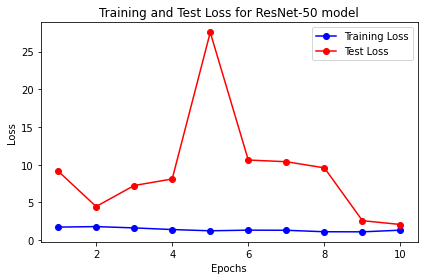

In [32]:
# Define the actual number of epochs
epochs_ResNet = range(1, num_epochs_ResNet + 1)

# Plot for training and test losses on the same axes
plt.plot(epochs_ResNet, epoch_train_losses_ResNet, 'bo-', label='Training Loss')
plt.plot(epochs_ResNet, epoch_test_losses_ResNet, 'ro-', label='Test Loss')
plt.title('Training and Test Loss for ResNet-50 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

It is obvious that the test loss shows a high variation, this could indicate overfitting of the model to the training data, because the test loss should ideally decrease steadily or remain stable if the model generalizes well. However, towards the end, the two losses appear to converge, which may indicate that the model is starting to stabilize its learning. Thus, the model could benefit from regularization techniques or readjustment of hyperparameters to improve its ability to generalize to new data.

### Regularization

After testing our model, we will seek to improve its performance. One of the techniques commonly used in machine learning is L2 regularization. Regularization is a commonly used technique to prevent overfitting and involves adding a penalty to the model weights during training, so that the weights do not become excessively large. L2 regularization, one of the most commonly used regularization methods, adds a penalty term to the model loss function, which depends on the sum of the squares of the model weights. To do this, in the following code we use the Adam optimizer to train our model by specifying the parameter `weight_decay` equals to 0.001, this parameter controls the strength of L2 regularization. The higher its value, the stronger the regularization. Using weight_decay automatically adds the L2 penalty to weight updates during training to discourage them from getting too big. Let's see how, thanks to L2 regularization, the model performs by calculating the accuracy.

In [35]:
# Prepare the model :
model_ResNet_Reg, criterion_ResNet_Reg, optimizer_ResNet_Reg = prep_resnet(len(train_data.classes), learning_rate=0.001, weight_decay_value=0.001)

# Initialize lists to store metrics
epoch_train_losses_ResNet_Reg = []
epoch_test_losses_ResNet_Reg = []

# Train the model :

# Number of training epochs chosen
num_epochs_ResNet_Reg = 10  

# Use of GPU if available, otherwise of CPU
device_ResNet_Reg = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_ResNet_Reg.to(device_ResNet_Reg)

# Training loop over multiple epochs (10 epochs)
for epoch in range(num_epochs_ResNet_Reg):
    running_train_loss_ResNet_Reg = train_model(model_ResNet_Reg, train_loader, device_ResNet_Reg, optimizer_ResNet_Reg, criterion_ResNet_Reg, epoch, num_epochs_ResNet_Reg)
    
    # Follow the evolution of losses over time   
    average_train_loss_ResNet_Reg = running_train_loss_ResNet_Reg / len(train_loader)
    epoch_train_losses_ResNet_Reg.append(average_train_loss_ResNet_Reg)

    # Evaluate the model :
    all_labels_ResNet_Reg, all_predictions_ResNet_Reg, all_probabilities_np_ResNet_Reg, running_test_loss_ResNet_Reg = eval_model(model_ResNet_Reg, test_loader, device_ResNet_Reg, criterion_ResNet_Reg)
    
    # Follow the evolution of losses over time 
    average_test_loss_ResNet_Reg = running_test_loss_ResNet_Reg / len(test_loader)
    epoch_test_losses_ResNet_Reg.append(average_test_loss_ResNet_Reg)
    
# Calculate accuracy by comparing actual labels with predicted labels
accuracy_ResNet_Reg = np.mean(np.array(all_labels_ResNet_Reg) == np.array(all_predictions_ResNet_Reg))

# Print the accuracy as a percentage
print(f"Accuracy (ResNet-50 Regularized (L2)) : {accuracy_ResNet_Reg * 100:.2f}%")

Epoch [1/10] - Loss : 1.7334003150463104
Epoch [2/10] - Loss : 1.5947926342487335
Epoch [3/10] - Loss : 1.458832710981369
Epoch [4/10] - Loss : 1.4943057298660278
Epoch [5/10] - Loss : 1.43660107254982
Epoch [6/10] - Loss : 1.2352532148361206
Epoch [7/10] - Loss : 1.4016184210777283
Epoch [8/10] - Loss : 1.1347966939210892
Epoch [9/10] - Loss : 1.0860480219125748
Epoch [10/10] - Loss : 1.1405649036169052
Accuracy (ResNet-50 Regularized (L2)) : 52.73%


We therefore obtain better accuracy when the model is regularized using L2 regularization. This means the model is less prone to overfitting, more stable during training, simpler, and generalizes better to new data. So L2 regularization allowed us to improve the performance of our model. Let's check if this is also reflected in the loss curves.

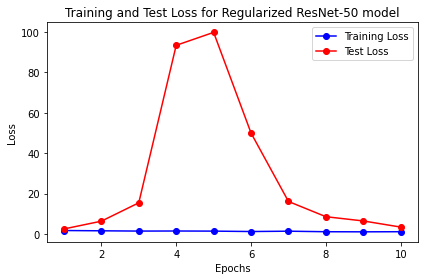

In [36]:
# Define the actual number of epochs
epochs_ResNet_Reg = range(1, num_epochs_ResNet_Reg + 1)

# Plot for training and test losses on the same axes
plt.plot(epochs_ResNet_Reg, epoch_train_losses_ResNet_Reg, 'bo-', label='Training Loss')
plt.plot(epochs_ResNet_Reg, epoch_test_losses_ResNet_Reg, 'ro-', label='Test Loss')
plt.title('Training and Test Loss for Regularized ResNet-50 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Given the sharp decrease in test loss after epoch 6 in the graph, if this downward trend continues into the last 4 epochs with the test loss remaining close to the training loss, it would suggest that the regularization techniques are effective and that the model is not overfitting. Conversely, if the test loss starts to increase again or diverges from the training loss, this would be a sign that overfitting may still be an issue.

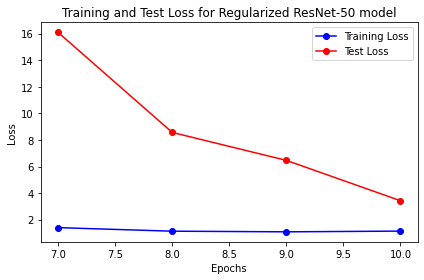

In [38]:
# Define the actual number of epochs
epochs_ResNet_Reg = range(7, num_epochs_ResNet_Reg + 1)

# Plot for training and test losses on the same axes
plt.plot(epochs_ResNet_Reg, epoch_train_losses_ResNet_Reg[6:], 'bo-', label='Training Loss')
plt.plot(epochs_ResNet_Reg, epoch_test_losses_ResNet_Reg[6:], 'ro-', label='Test Loss')
plt.title('Training and Test Loss for Regularized ResNet-50 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

From the training and testing loss graph for the ResNet-50 model regularized over the last 4 epochs, it is evident that regularization has a beneficial effect on the model performance. The training loss remains low and stable, indicating that the model maintains a good fit to the training data without overlearning. More importantly, the test loss steadily decreases and approaches the training loss, so the model generalizes well and regularization effectively protects it against overfitting. This suggest that the model is likely to perform well on new data, especially if the parameters are adjusted.

### Hyperparameter Tuning
Hyperparameterization is the process of adjusting the hyperparameters of a machine learning model to optimize its performance on a dataset. Hyperparameters are parameters that are not learned directly from the data, unlike the parameters of the model itself. Hyperparameterization is essential for our study since the presenttrained ResNet model that we used is sensitive to the hyperparameter values. By adjusting these hyperparameters appropriately, we can achieve better model performance on our test data.

The scheduler allows you to adjust the learning rate during training according to a certain pattern. For example, you might want to start with a high learning rate to progress quickly toward potential solutions, then decrease the rate as you get closer to an optimal solution in order to fine-tune the model weights more delicately. So, regarding the learning rate, we will continue with the use of a scheduler putting the value found thanks to the hyperparameterization in order to help improve the performance of the model and accelerate the convergence during training. Thus, regarding the hyperparameterization of the learning rate, we will continue with the use of a scheduler in order to help improve the performance of the model and accelerate convergence during training. A `step_size`, parameter determining after how many epochs the learning rate will be adjusted, equal to 7 will be preferred, which means that the learning rate will be reduced every 7 training cycles. This number is chosen based on how quickly the network is expected to converge to an optimal solution. A `gamma`, the parameter determining the learning rate reduction factor, equal to 0.1 will be preferred, which means that the learning rate will be multiplied by 0.1 (reduced by 90%) at each step. The idea behind these adjustments is to allow the model to take larger steps at the beginning (when the learning rate is high) to quickly explore the solution space, then take small steps as the learning rate progresses and you get closer to an optimal solution, in order to refine that solution without exceeding it.

The number of training `epochs` refers to the number of times the training data set is presented to the model during the training process. This is an important hyperparameter because it can have a significant impact on model performance. If the number of epochs is too low, the model may not have time to learn complex patterns in the data, which can lead to underfitting. Conversely, if the number of epochs is too high, the model risks memorizing training data instead of learning general patterns, which can lead to overfitting. Thus, our goal is to determine the optimal number of epochs (ranging from 0 to 200) for our model, so as to maximize its accuracy.

In [ ]:
# Preparing the model
model_ResNet_Epoch, criterion_ResNet_Epoch, optimizer_ResNet_Epoch = prep_resnet(len(train_data.classes), learning_rate=0.001)

# Initialize lists to store metrics
epoch_train_losses_ResNet_Epoch = []
epoch_test_losses_ResNet_Epoch = []

# Initializing the scheduler
scheduler_ResNet_Epoch = optim.lr_scheduler.StepLR(optimizer_ResNet_Epoch, step_size=7, gamma=0.1)

# Setting up training parameters
num_epochs_max = 200
best_epoch = 0
best_accuracy = 0
accuracy_history = []
cumulative_accuracy = []

# Setting up the device
device_ResNet_Epoch = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ResNet_Epoch.to(device_ResNet_Epoch)

# Training and evaluation loop
for epoch in range(num_epochs_max):
    running_train_loss_ResNet_Epoch = train_model(model_ResNet_Epoch, train_loader, device_ResNet_Epoch, optimizer_ResNet_Epoch, criterion_ResNet_Epoch, epoch, num_epochs_max)
    
    # Update the learning rate
    scheduler_ResNet_Epoch.step()
    
    # Follow the evolution of losses over time   
    average_train_loss_ResNet_Epoch = running_train_loss_ResNet_Epoch / len(train_loader)
    epoch_train_losses_ResNet_Epoch.append(average_train_loss_ResNet_Epoch)

    # Evaluate the model :
    all_labels_ResNet_Epoch, all_predictions_ResNet_Epoch, _, running_test_loss_ResNet_Epoch = eval_model(model_ResNet_Epoch, test_loader, device_ResNet_Epoch, criterion_ResNet_Epoch)

    # Follow the evolution of losses over time 
    average_test_loss_ResNet_Epoch = running_test_loss_ResNet_Epoch / len(test_loader)
    epoch_test_losses_ResNet_Epoch.append(average_test_loss_ResNet_Epoch) 
    
    # Calculate the accuracy for the current epoch and store it
    epoch_accuracy = accuracy_score(all_labels_ResNet_Epoch, all_predictions_ResNet_Epoch)
    accuracy_history.append(epoch_accuracy)

    # Calculate the cumulative average accuracy up to the current epoch and store it
    cumulative_avg_accuracy = np.mean(accuracy_history)
    cumulative_accuracy.append(cumulative_avg_accuracy)

    # Check if the current epoch's accuracy is better than the best accuracy so far
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy # Update the best accuracy
        best_epoch = epoch + 1 # Update the best epoch

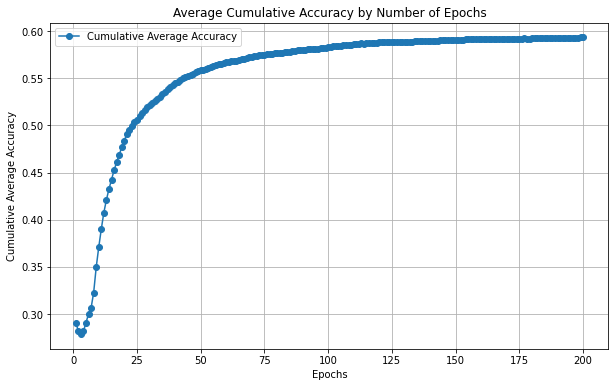

The epoch that gives the best accuracy is 21 with an accuracy of 0.50


In [62]:
# Plotting the cumulative average accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_max + 1), cumulative_accuracy, label='Cumulative Average Accuracy', marker='o')
plt.title('Average Cumulative Accuracy by Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Printing the best epoch and accuracy
print(f"The epoch that gives the best accuracy is {best_epoch} with an accuracy of {best_accuracy:.2f}")

From the graph, we observe that the accuracy increases quickly at the start of training, which is common since the model learns a lot of new information quickly. Then, the growth in accuracy slows down and begins to stabilize as the number of epochs increases, which is typical when the model begins to converge and has learned a significant amount of the data's features. Toward the end of the graph, after about 125 epochs, the average cumulative accuracy appears to reach a plateau, indicating that the model is no longer significantly improving with additional training. This could mean that the model has reached its maximum learning capacity on the data provided, thus, the optimal number of `epochs` for our model is 125.

In the same way as before, let's try to understand the behavior of our model by displaying the loss curves.

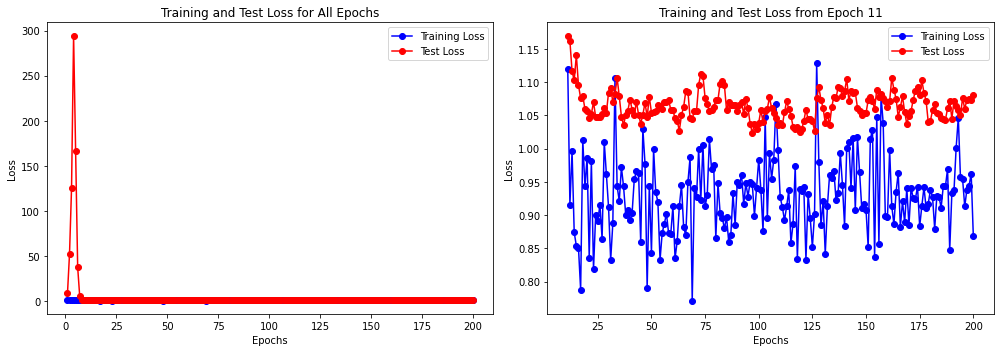

In [55]:
# Define the actual number of epochs for both plots
epochs_ResNet_Epoch_full = range(1, num_epochs_max + 1)
epochs_ResNet_Epoch_partial = range(11, num_epochs_max + 1)

# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot for all epochs
ax1.plot(epochs_ResNet_Epoch_full, epoch_train_losses_ResNet_Epoch, 'bo-', label='Training Loss')
ax1.plot(epochs_ResNet_Epoch_full, epoch_test_losses_ResNet_Epoch, 'ro-', label='Test Loss')
ax1.set_title('Training and Test Loss for All Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for epochs starting from 11
ax2.plot(epochs_ResNet_Epoch_partial, epoch_train_losses_ResNet_Epoch[10:], 'bo-', label='Training Loss')
ax2.plot(epochs_ResNet_Epoch_partial, epoch_test_losses_ResNet_Epoch[10:], 'ro-', label='Test Loss')
ax2.set_title('Training and Test Loss from Epoch 11')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust the layout so that both subplots fit well in the figure
plt.tight_layout()
plt.show()

Focusing on the second graph, which eliminates the initial loss peak observed in the first graph, we see a more stable and less erratic variation in training and testing losses than the previously tested model (without schedular for learning_rate, trained over only 10 epochs), with values fluctuating around a certain average, indicating more predictable behavior of the model over epochs. The closeness of the two curves suggests that the model is not excessively overfitting, and the introduction of an appropriate weight decay could help to further smooth these curves, potentially reducing the variance of test losses and improving the generalization of the model. We are therefore considering the hyperparameterization of the weight decay to optimize the regularization of the model.

Weight decay aims to prevent overfitting by adding a penalty to the model weights during training, as we explained in the previous section. The regularization coefficient is a hyperparameter that must be tuned when training the model because its value determines the strength of the penalty applied to the weights. A higher regularization coefficient will result in a stronger penalty, which can lead to smaller weights. To perform hyperparameter tuning for the weight decay parameter, we can define a range of values to test for the `weight_decay` and then train your model using each value to see which one results in the highest accuracy.

In [ ]:
# Define the number of training epochs and range of weight decay values
num_epochs_ResNet_WD = 10
weight_decay_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Initialize variables to store the best weight decay value and corresponding accuracy
best_weight_decay = 0
best_accuracy = 0

# Dictionary to keep track of accuracy for each weight decay value
weight_decay_accuracy_history = {}

# Iterate over each weight decay value to find the optimal one
for weight_decay in weight_decay_values:

    # Prepare the model with the current weight decay value
    model_ResNet_WD, criterion_ResNet_WD, optimizer_ResNet_WD = prep_resnet(len(train_data.classes), learning_rate=0.001, weight_decay_value=weight_decay)

    # Initialize the learning rate scheduler
    scheduler_ResNet_WD = optim.lr_scheduler.StepLR(optimizer_ResNet_WD, step_size=7, gamma=0.1)

    # Setup the device
    device_ResNet_WD = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_ResNet_WD.to(device_ResNet_WD)

    # List to store accuracies for each epoch
    epoch_accuracies = []

    # Training and evaluation loop for the current weight decay value
    for epoch in range(num_epochs_ResNet_WD):
        # Train the model
        _ = train_model(model_ResNet_WD, train_loader, device_ResNet_WD, optimizer_ResNet_WD, criterion_ResNet_WD, epoch, num_epochs_ResNet_WD)

        # Update the learning rate
        scheduler_ResNet_WD.step()

        # Evaluate the model
        all_labels, all_predictions, _, _ = eval_model(model_ResNet_WD, test_loader, device_ResNet_WD, criterion_ResNet_WD)

        # Calculate accuracy for the current epoch
        epoch_accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(epoch_accuracy)

    # Calculate the average accuracy for the current weight decay value
    average_accuracy = np.mean(epoch_accuracies)
    weight_decay_accuracy_history[weight_decay] = average_accuracy

    # Update the best weight decay value if the current one is better
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_weight_decay = weight_decay

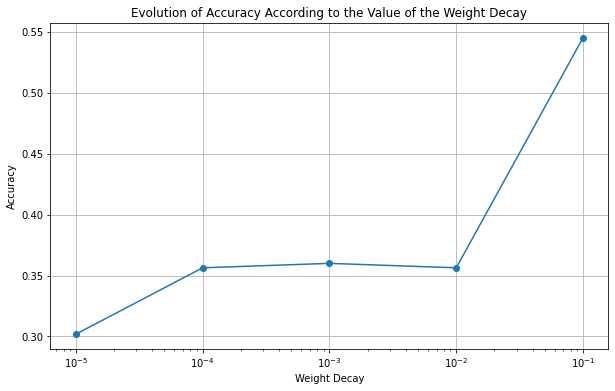

 The weight decay that gives the best accuracy is 0.1 with an accuracy of 0.55


In [98]:
# Plot the graph of accuracy vs. weight decay values
plt.figure(figsize=(10, 6))
plt.plot(list(weight_decay_accuracy_history.keys()), list(weight_decay_accuracy_history.values()), marker='o')
plt.xscale('log')
plt.title('Evolution of Accuracy According to the Value of the Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print the best weight decay value and its accuracy
print(f" The weight decay that gives the best accuracy is {best_weight_decay} with an accuracy of {best_accuracy:.2f}")

The graph shows that the best `weight_decay` is, by far, 0.1, corresponding to an accuracy of 50%. However, it is worth noting a limitation in these results since the hyperparameterization was not tested on 125 epochs, which had been identified as the optimal number when hyperparameterizing the epochs. The training process over 125 epochs for 5 weight decay values is very long and computationally demanding, which explains why this configuration has not been explored. Therefore, although we have identified a weight decay that significantly improves accuracy, this value might not be optimal when considering a higher number of epochs. It is possible that accuracy could be further improved with more prolonged training, allowing the model to fully benefit from the regularization effect

The batch size is a hyperparameter that determines the number of training examples that are used in each iteration to update the model weights during the training process. In general, there is a trade-off between accuracy and training speed. A larger batch size speeds up training, but can lead to less accurate models. A smaller batch size can improve accuracy, but at the cost of increased training time. However, when dealing with a small dataset, there is a higher risk of overfitting because the model can easily memorize the training data instead of learning general patterns. To reduce this risk, it may be helpful to use a smaller batch size. A smaller batch size introduces some variability into the optimization, which can help regularize the model. So, in general, for a small dataset, it is common to parameterize the model with a `batch_size` equal to 32, rather than 64 or 128. Thus, since we have a small dataset, we have chosen not to not do hyper parametrization for the batch size and avoid overfitting while maximizing the use of available data.

Now that we have determined the optimal parameters for our model, it is time to put them to the test to evaluate if they improve our performance. We will therefore carry out a final evaluation to measure the effectiveness of our model with the new parameters we have chosen. This will allow us to confirm if these parameters are really suitable for our task and if the model performance improves compared to the previously used parameters.

In [ ]:
# Prepare the model :
model_ResNet_HyperP, criterion_ResNet_HyperP, optimizer_ResNet_HyperP = prep_resnet(len(train_data.classes), learning_rate=0.001, weight_decay_value=0.1)

# Initialize lists to store metrics
epoch_train_losses_ResNet_HyperP = []
epoch_test_losses_ResNet_HyperP = []

# Train the model :

# Number of training epochs chosen
num_epochs_ResNet_HyperP = 125  

# Use of GPU if available, otherwise of CPU
device_ResNet_HyperP = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_ResNet_HyperP.to(device_ResNet_HyperP)

# Initialize the learning rate scheduler
scheduler_ResNet_HyperP = optim.lr_scheduler.StepLR(optimizer_ResNet_HyperP, step_size=7, gamma=0.1)

# Training loop over multiple epochs (10 epochs)
for epoch in range(num_epochs_ResNet_HyperP):
    running_train_loss_ResNet_HyperP = train_model(model_ResNet_HyperP, train_loader, device_ResNet_HyperP, optimizer_ResNet_HyperP, criterion_ResNet_HyperP, epoch, num_epochs_ResNet_HyperP)
    
    # Update the learning rate
    scheduler_ResNet_HyperP.step()
    
    # Follow the evolution of losses over time   
    average_train_loss_ResNet_HyperP = running_train_loss_ResNet_HyperP / len(train_loader)
    epoch_train_losses_ResNet_HyperP.append(average_train_loss_ResNet_HyperP)

    # Evaluate the model :
    all_labels_ResNet_HyperP, all_predictions_ResNet_HyperP, all_probabilities_np_ResNet_HyperP, running_test_loss_ResNet_HyperP = eval_model(model_ResNet_HyperP, test_loader, device_ResNet_HyperP, criterion_ResNet_HyperP)
    
    # Follow the evolution of losses over time 
    average_test_loss_ResNet_HyperP = running_test_loss_ResNet_HyperP / len(test_loader)
    epoch_test_losses_ResNet_HyperP.append(average_test_loss_ResNet_HyperP)

We'll begin by computing accuracy as a measure to gauge the percentage of correct predictions made by the model.

In [100]:
# Calculate accuracy by comparing actual labels with predicted labels
accuracy_ResNet_HyperP = np.mean(np.array(all_labels_ResNet_HyperP) == np.array(all_predictions_ResNet_HyperP))

# Print the accuracy as a percentage
print(f"Accuracy (ResNet-50 Hyper Parametrized) : {accuracy_ResNet_HyperP * 100:.2f}%")

Accuracy (ResNet-50 Hyper Parametrized) : 58.18%


Hyperparameter optimization led to a significant improvement in model accuracy, reaching an accuracy of over 58%. This increase in accuracy indicates that the model is better suited to the specific data it was trained on and is able to generalize its predictions more successfully.

In order to compare our results with this new ResNet-50 model with hyperparameterization, and to realize the benefit provided by the optimization of the hyperparameters, let's calculate the F1 score of each class

In [101]:
# Define class names
class_names_ResNet_HyperP = ["brick", "concrete", "mix", "other", "stone"]

# Calculate F1 score for each class and store them in a list
f1_scores_ResNet_HyperP = f1_score(all_labels_ResNet_HyperP, all_predictions_ResNet_HyperP, average=None)

# Print F1 score for each class
for i, score in enumerate(f1_scores_ResNet_HyperP):
    print(f"F1 score for {class_names_ResNet_HyperP[i]} : {score:.2f}")

# Calculate the average F1 score across all classes
average_f1_score_ResNet_HyperP = f1_score(all_labels_ResNet_HyperP, all_predictions_ResNet_HyperP, average='weighted')

# Print the average F1 score
print()
print(f"Average F1 score (ResNet-50) : {average_f1_score_ResNet_HyperP:.2f}")

F1 score for brick : 0.69
F1 score for concrete : 0.74
F1 score for mix : 0.00
F1 score for other : 0.57
F1 score for stone : 0.36

Average F1 score (ResNet-50) : 0.52


The F1 score for each class was improved, suggesting a better balance between precision and recall, crucial aspects in evaluating models on multi-class classification tasks. However, the performance of the model on images categorized as “mix” remains a challenge. This could be due to the difficulty of distinguishing different materials on the same facade, a complex task that requires a high level of discernment on the part of the model to recognize varied and subtle patterns.

We generate visualizations to track changes in training and testing losses across epochs. These visualizations will help us determine if overfitting issues are resolved through parameter optimization.

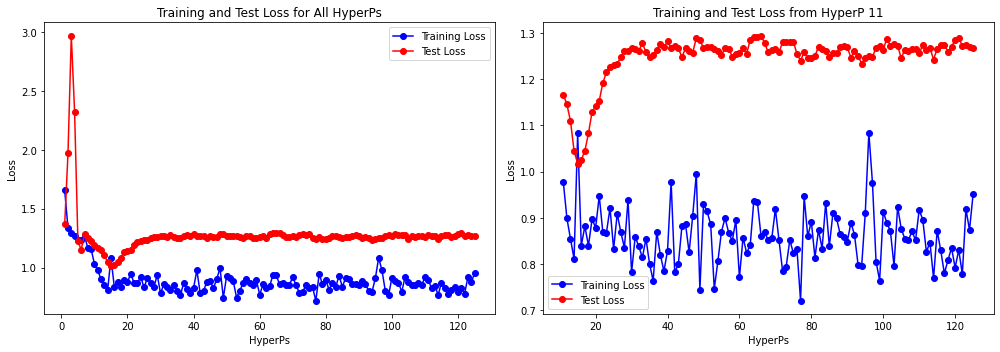

In [102]:
# Define the actual number of epochs for both plots
epochs_ResNet_HyperP_full = range(1, num_epochs_ResNet_HyperP + 1)
epochs_ResNet_HyperP_partial = range(11, num_epochs_ResNet_HyperP + 1)

# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot for all epochs
ax1.plot(epochs_ResNet_HyperP_full, epoch_train_losses_ResNet_HyperP, 'bo-', label='Training Loss')
ax1.plot(epochs_ResNet_HyperP_full, epoch_test_losses_ResNet_HyperP, 'ro-', label='Test Loss')
ax1.set_title('Training and Test Loss for All Epochs')
ax1.set_xlabel('HyperPs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for epochs starting from 11
ax2.plot(epochs_ResNet_HyperP_partial, epoch_train_losses_ResNet_HyperP[10:], 'bo-', label='Training Loss')
ax2.plot(epochs_ResNet_HyperP_partial, epoch_test_losses_ResNet_HyperP[10:], 'ro-', label='Test Loss')
ax2.set_title('Training and Test Loss From Epoch 11')
ax2.set_xlabel('HyperPs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust the layout so that both subplots fit well in the figure
plt.tight_layout()
plt.show()

The plots indicate that the model does not suffer from overfitting significantly, as it maintains a test loss comparable to the training loss throughout the tuning process. This regularization is likely the result of an appropriate combination of hyperparameters, such as learning rate, decay weight, and the use of an efficient and optimized regularization technique.

Hyperparameterization proved to be a winning strategy, significantly improving the performance of the pre-trained ResNet50 model, resulting in high accuracy and boosted F1 scores. The regularization applied during this process also contributes to the stability of the model, avoiding overfitting and ensuring efficient generalization to new data.

### Training on Facade Materials

In order to improve the performance of our material detection model on images of building facades, we considered an approach that could perhaps strengthen its ability to distinguish between different types of materials.


Our first step is to enrich our training dataset using a more accurate and diverse dataset. To do this, we created a new dataset that we named “materials”. This dataset contains images of materials corresponding to five distinct classes: "brick", "stone", "concrete", "mix", and "other". The material images we collected are highly specific. For each class, we collected around ten highly zoomed-in images of building facades, highlighting the characteristics of construction materials. For example, for the "brick" class, we collected images of facades mainly built in bricks. Likewise, we have gathered images of facades mainly composed of "stone", "concrete", "mix", and "other", where "other" includes facades partially obstructed by elements such as trees, as well as facades made of wood, glass or any other materials different from other classes. The main idea behind training on such precise images of materials is that it could help the model improve its ability to distinguish between different types of materials present in images of building facades. 

We divide our new training into two phases :
- The "first training" on material images to familiarize the model with the characteristics of construction materials.
- The "second training" on images of building facades, using the knowledge acquired during the first training for better performance.

Below you will find a representative example of the types of images we use for the first phase :
<img src="/illustrations/meterials.jpg" width="800">

We hope that this improved approach to model training will achieve more accurate and reliable results in detecting materials on images of building facades.

In this new approach, the first step remains unchanged from that previously employed : we apply the data augmentation technique to our training set, consisting of images of materials from the "materials" folder. This data augmentation step for the training dataset, composed of material images, is of capital importance. Indeed, it aims to reproduce the real variations that the model could be confronted with during its subsequent use for testing on images of building facades.

In [103]:
# Find normalization values :

# Define a dataset without normalization for calculating mean and std for materials dataset
materials_unnormalized_dataset = datasets.ImageFolder("materials", transform=transforms.ToTensor())

# Calculate mean and standard deviation across the entire dataset for testing set
data_loader_materials = torch.utils.data.DataLoader(materials_unnormalized_dataset, batch_size=1, shuffle=False)

materials_mean = torch.zeros(3)
materials_std = torch.zeros(3)
total_samples_materials = len(materials_unnormalized_dataset)

# Iterate through the dataset to compute the mean and standard deviation for materials dataset
for inputs, _ in data_loader_materials:
    materials_mean += torch.mean(inputs, dim=(0, 2, 3)) # Calculate mean along channels (RGB)
    materials_std += torch.std(inputs, dim=(0, 2, 3))  # Calculate std along channels (RGB)

materials_mean /= total_samples_materials
materials_std /= total_samples_materials

# Load materials dataset
materials_data = datasets.ImageFolder("materials", transform=data_transforms['train'])

# Create materials dataset
materials_loader = DataLoader(materials_data, batch_size=32, shuffle=True)

Now that we have our first training dataset, we are ready to implement the ResNet model. Our training approach will take place in two distinct stages. Firstly, we will train the model on the dataset composed of images of materials, then secondly on the training set corresponding to images of building facades. It is important to note that using previously determined parameter values during hyperparameterization is no longer relevant, since the model is now not training on the same dataset. For this new training phase, we will opt for a number of epochs equal to 10, in order to be able to compare the accuracy results with the first results obtained for ResNet. However, it is essential to emphasize that we will continue to use regularization mechanisms and a scheduler for the learning rate. These techniques, as we have seen, are crucial to improve the generalization of the model and guarantee its stability throughout the training process.

In [108]:
# Prepare the model using the prep_resnet function
model_ResNet_Materials, criterion_ResNet_Materials, optimizer_ResNet_Materials = prep_resnet(len(train_data.classes), learning_rate=0.001)

# Setup the device
device_ResNet_Materials = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ResNet_Materials.to(device_ResNet_Materials)

# Define the number of training epochs
num_epochs_ResNet_Materials = 10

# First training loop over multiple epochs (10 epochs) using the materials_loader
print("Training on material set :")
for epoch in range(num_epochs_ResNet_Materials):
    train_model(model_ResNet_Materials, materials_loader, device_ResNet_Materials, optimizer_ResNet_Materials, criterion_ResNet_Materials, epoch, num_epochs_ResNet_Materials)

# Second training loop over multiple epochs (10 epochs) using the train_loader
print("Training on train set :")
for epoch in range(num_epochs_ResNet_Materials):
    train_model(model_ResNet_Materials, train_loader, device_ResNet_Materials, optimizer_ResNet_Materials, criterion_ResNet_Materials, epoch, num_epochs_ResNet_Materials)

# Evaluate the model using the eval_model function
all_labels_ResNet_Materials, all_predictions_ResNet_Materials, _, _ = eval_model(model_ResNet_Materials, test_loader, device_ResNet_Materials, criterion_ResNet_Materials)

Training on material set :
Epoch [1/10] - Loss : 1.5361908674240112
Epoch [2/10] - Loss : 0.9131339490413666
Epoch [3/10] - Loss : 0.7032139003276825
Epoch [4/10] - Loss : 0.6380998492240906
Epoch [5/10] - Loss : 0.7446267008781433
Epoch [6/10] - Loss : 0.7303551807999611
Epoch [7/10] - Loss : 0.8981789946556091
Epoch [8/10] - Loss : 0.45297111570835114
Epoch [9/10] - Loss : 0.513998493552208
Epoch [10/10] - Loss : 0.7224536240100861
Training on train set :
Epoch [1/10] - Loss : 3.3527087569236755
Epoch [2/10] - Loss : 1.7775448560714722
Epoch [3/10] - Loss : 1.5907103419303894
Epoch [4/10] - Loss : 1.4817147254943848
Epoch [5/10] - Loss : 1.3468952775001526
Epoch [6/10] - Loss : 1.2674040794372559
Epoch [7/10] - Loss : 1.2678264379501343
Epoch [8/10] - Loss : 1.193983554840088
Epoch [9/10] - Loss : 1.2572335004806519
Epoch [10/10] - Loss : 1.2373672723770142


In [109]:
# Calculate and print accuracy
accuracy_ResNet_Materials = accuracy_score(all_labels_ResNet_Materials, all_predictions_ResNet_Materials)
print(f"Accuracy (ResNet-50 with two training loops) : {accuracy_ResNet_Materials * 100:.2f}%")

Accuracy (ResNet-50 with two training loops) : 52.73%


The two-step training approach, first training the model on a specialized facade materials dataset before re-training it on full facade images, proved extremely beneficial. Indeed, this method made it possible to increase the accuracy by more than 10%, going from 41.82% to 52.73%. This progression demonstrates the effectiveness of a targeted and iterative training strategy.

Although we did not have the opportunity to apply hyperparameterization and regularization at this phase due to time constraints, it is reasonable to think that these techniques could have led to even more marked improvements. Regularization could, in particular, have helped prevent overfitting, and hyperparameterization would have refined the model settings for optimized performance. Looking to the future, it is clear that continuing this training method, leveraging a larger material dataset, increasing the number of training epochs, and integrating efficient hyperparameterization with good regularization, could undoubtedly lead to even more satisfactory results.

## C. Our Model

Having evaluated two models, it is now an opportune time to explore creating a custom model. Our model, with a simple model structure, will be specially designed to classify buildings according to their facade materials, while minimizing the risks of overfitting.

### CNN Architecture
Let's create a convolutional neural network (CNN) model that we will name SimpleCNN using the PyTorch library. This model represents a basic architecture for image classification based on building facade materials. It is designed to be trained and used to predict the category of images based on the materials they present.

The `SimpleCNN` model includes five convolutional layers (`self.layer1` to `self.layer5`), each followed by a ReLU activation function to introduce non-linearity into the model. Between the convolution layers, max-pooling operations are used to reduce the dimension of the feature maps. These convolution layers progressively capture more and more abstract features as information is propagated through the network. After the convolution layers, a dropout layer (`self.dropout`) is introduced for regularization, which helps reduce overfitting by randomly deactivating a fraction of the neurons during training. Finally, the model ends with a fully connected layer, `self.fc`, which takes the output of the convolution layers and rearranges it into a 1D vector. This fully connected layer performs the final classification by producing scores for each class. The `forward` method of the model specifies how data should be processed through the model. Data pass through the convolutional layers, get flattened, and then pass through the fully connected layer to obtain classification scores. The classification scores are returned as the output of the forward method.

In [128]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),  # Convolutional layer 1
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling layer

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # Convolutional layer 2
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling layer

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Convolutional layer 3
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling layer

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Convolutional layer 4
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling layer

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Convolutional layer 5
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling layer

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        # Note : Adjust the input size of the first linear layer according to your input image size
        self.fc = nn.Linear(256 * 7 * 7, num_classes)  # Fully connected layer with the specified output size

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # Flatten the output for the fully connected layer
        x = x.view(-1, 256 * 7 * 7)  # Reshape the tensor to a 1D vector

        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc(x)  # Fully connected layer for classification
        
        return x

### Training and Evaluation
Now let's prepare, train and evaluate the convolutional neural network (CNN) model we created to automatically classify images based on the facade materials they represent. Our objective is to obtain a powerful model capable of carrying out these classifications precisely, despite its limitations.

In [130]:
# Prepare the model :
model_SimpleCNN = SimpleCNN(num_classes=5)  # Number of facade material types

# Define the loss function and optimizer
criterion_SimpleCNN = nn.CrossEntropyLoss() # Use CrossEntropyLoss for classification
optimizer_SimpleCNN = optim.Adam(model_SimpleCNN.parameters(), lr=0.001) # Use Adam optimizer

# Initialize lists to store metrics
epoch_train_losses_SimpleCNN = []
epoch_test_losses_SimpleCNN = []

# Train the model :

# Number of training epochs chosen
num_epochs_SimpleCNN = 10  

# Use of GPU if available, otherwise of CPU
device_SimpleCNN = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_SimpleCNN.to(device_SimpleCNN)

# Training loop over multiple epochs (10 epochs)
for epoch in range(num_epochs_SimpleCNN):
    running_train_loss_SimpleCNN = train_model(model_SimpleCNN, train_loader, device_SimpleCNN, optimizer_SimpleCNN, criterion_SimpleCNN, epoch, num_epochs_SimpleCNN)
    
    # Follow the evolution of losses over time   
    average_train_loss_SimpleCNN = running_train_loss_SimpleCNN / len(train_loader)
    epoch_train_losses_SimpleCNN.append(average_train_loss_SimpleCNN)

    # Evaluate the model :
    all_labels_SimpleCNN, all_predictions_SimpleCNN, all_probabilities_np_SimpleCNN, running_test_loss_SimpleCNN = eval_model(model_SimpleCNN, test_loader, device_SimpleCNN, criterion_SimpleCNN)
    
    # Follow the evolution of losses over time 
    average_test_loss_SimpleCNN = running_test_loss_SimpleCNN / len(test_loader)
    epoch_test_losses_SimpleCNN.append(average_test_loss_SimpleCNN)

Epoch [1/10] - Loss : 1.5881142020225525
Epoch [2/10] - Loss : 1.577371597290039
Epoch [3/10] - Loss : 1.574102520942688
Epoch [4/10] - Loss : 1.555056869983673
Epoch [5/10] - Loss : 1.5505645275115967
Epoch [6/10] - Loss : 1.5398782193660736
Epoch [7/10] - Loss : 1.5497158467769623
Epoch [8/10] - Loss : 1.5342918634414673
Epoch [9/10] - Loss : 1.5320660471916199
Epoch [10/10] - Loss : 1.5107611417770386


In [135]:
# Calculate accuracy by comparing actual labels with predicted labels
accuracy_SimpleCNN = np.mean(np.array(all_labels_SimpleCNN) == np.array(all_predictions_SimpleCNN))

# Print the accuracy as a percentage
print(f"Accuracy (SimpleCNN) : {accuracy_SimpleCNN * 100:.2f}%")

Accuracy (SimpleCNN) : 40.00%


SimpleCNN model showed decent performance in terms of accuracy, slightly below that of ResNet-50, but significantly better than that of VGG-16.

In [136]:
# Define class names
class_names_SimpleCNN = ["brick", "concrete", "mix", "other", "stone"]

# Calculate F1 score for each class and store them in a list
f1_scores_SimpleCNN = f1_score(all_labels_SimpleCNN, all_predictions_SimpleCNN, average=None)

# Print F1 score for each class
for i, score in enumerate(f1_scores_SimpleCNN):
    print(f"F1 score for {class_names_SimpleCNN[i]} : {score:.2f}")

# Calculate the average F1 score across all classes
average_f1_score_SimpleCNN = f1_score(all_labels_SimpleCNN, all_predictions_SimpleCNN, average='weighted')

# Print the average F1 score
print()
print(f"Average F1 score (SimpleCNN) : {average_f1_score_SimpleCNN:.2f}")

F1 score for brick : 0.67
F1 score for concrete : 0.45
F1 score for mix : 0.00
F1 score for other : 0.00
F1 score for stone : 0.00

Average F1 score (SimpleCNN) : 0.28


A weakness of our model lies in its ability to distinguish more complex facade materials. In particular, the F1 scores for the "mix", "other" and "stone" classes are relatively low, all at 0. This means that the model has difficulty correctly classifying facades with these materials, which can be problematic in real situations where the variety of materials is important.

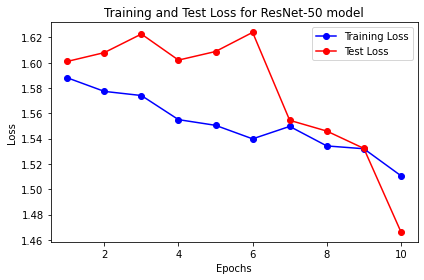

In [137]:
# Define the actual number of epochs
epochs_SimpleCNN = range(1, num_epochs_SimpleCNN + 1)

# Plot for training and test losses on the same axes
plt.plot(epochs_SimpleCNN, epoch_train_losses_SimpleCNN, 'bo-', label='Training Loss')
plt.plot(epochs_SimpleCNN, epoch_test_losses_SimpleCNN, 'ro-', label='Test Loss')
plt.title('Training and Test Loss for ResNet-50 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Adding the Dropout layer effectively prevented the model from overlearning, as evidenced by the loss curves for the test and training sets remaining close to each other. This indicates a correct generalization of the model.

# 4. Summary
In this section, we focus on evaluating the performance of the models on a set of test images. Our goal is to assess the model's ability to accurately classify these test images into their respective classes. This evaluation process will enable us to provide examples of image evaluations performed by the model, determining whether it correctly classifies the images into the appropriate categories or not.

## Test Images

In this section, we have gathered ten new test images manually by exploring Google Street View in Lausanne and its surroundings. Each of these images corresponds to one of the five predefined classes. Below, you can find the ten selected images, with their respective names and class, for evaluation :
<img src="/illustrations/tests.jpg" width="800">

These images, which are in the `images_test` file, will be used to assess the model's performance in classifying them into their respective categories.

In [110]:
# Image preprocessing function
def preprocess_image(image_path):
    # Define a sequence of image transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)), # Resize the image to dimensions expected by the model (224x224 pixels)
        transforms.ToTensor(), # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Apply standard normalization for ResNet models
    ])
    
    # Open the image from the specified path and convert it to RGB mode
    image = Image.open(image_path).convert('RGB')
    
    # Apply the defined transformations and add a batch dimension
    return preprocess(image).unsqueeze(0)

# List of classes
classes = ['brick', 'concrete', 'mix', 'other', 'stone']

## Model Results

We will evaluate the performance of our best-performing ResNet-50 model, model_ResNet_ (), by testing its predictions on a set of 10 specific images. These images have been selected to represent real-world examples from our dataset. Our objective is to assess how accurately the model classifies these images into their respective categories.

In [111]:
# Device for execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model onto the device
model_ResNet_HyperP.to(device)
model_ResNet_HyperP.eval()

# Mapping of image indices to true classes
true_classes = {1: 'brick', 2: 'brick', 
                3: 'concrete', 4: 'concrete', 
                5: 'mix', 6: 'mix', 
                7: 'other', 8: 'other', 
                9: 'stone', 10: 'stone'}

# Prediction for each image
for i in range(1, 11):
    image_path = f'images_test/image_{i}.jpg'  # Path to the test image
    img = preprocess_image(image_path).to(device)  # Preprocess the image and move it to the selected device
    with torch.no_grad():
        outputs = model_ResNet_HyperP(img)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Find the predicted class index
        predicted_class = classes[predicted[0]]  # Get the class label corresponding to the predicted index
        true_class = true_classes[i]  # Get the true class for the image

    # Print the predicted and true class for each image
    print(f'image_{i} classified as : {predicted_class} (True class : {true_class})')

image_1 classified as : brick (True class : brick)
image_2 classified as : brick (True class : brick)
image_3 classified as : concrete (True class : concrete)
image_4 classified as : concrete (True class : concrete)
image_5 classified as : brick (True class : mix)
image_6 classified as : stone (True class : mix)
image_7 classified as : other (True class : other)
image_8 classified as : other (True class : other)
image_9 classified as : stone (True class : stone)
image_10 classified as : brick (True class : stone)


## Conclusion

In conclusion, our study based on ResNet-50 with optimized hyperparameters produces very satisfactory results which exceed our expectations, as evidenced by the test carried out previously on around ten new images collected. The performances of the model during this test are consistent with those obtained during the evaluation of the hyperparameterized ResNet-50 model (ResNet_HyperP), showing a great capacity to correctly classify new images of facades corresponding to the following three classes: bricks, concrete and mix. However, we observed specific difficulties in the classification of stone facades, with an F1-score of only 0.36, which explains why the model only managed to correctly classify one of the two images in this class. Additionally, the model generally struggles with mixed facades, due to the complexity involved in classifying images containing two different facade materials. This is likely due to the variety of colors and textures present, making the distinction between the two materials more difficult.